# Basic functionality

## Input data

We start by importing tobac:

In [5]:
import tobac

We will also need matplotlib in inline-mode for plotting and numpy:

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

Tobac works with a Python package called *xarray*, which introduces *DataArrays*. In a nutshell these are *Numpy*-arrays with labels. For a more extensive description have a look at the [Documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray).
    
There are several utilities implemented in tobac to create simple examples of such arrays. In this tutorial we will use the function *make_simple_sample_data_2D()*:

In [7]:
test_data = tobac.testing.make_simple_sample_data_2D()
test_data

<xarray.DataArray 'w' (time: 100, y: 50, x: 100)>
[500000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1

As you can see our generated data describes a field called 'w' with the unit m/s at 100, 50 and 100 datapoints of time, x and y. Additionally, the data contains the latitude and longitude coordinates of the field values. To access the values of 'w' in the first timeframe we can use

In [8]:
test_data.data[0]

array([[3.67879441e+00, 4.04541885e+00, 4.40431655e+00, ...,
        2.22319774e-16, 9.26766698e-17, 3.82489752e-17],
       [4.04541885e+00, 4.44858066e+00, 4.84324569e+00, ...,
        2.44475908e-16, 1.01912721e-16, 4.20608242e-17],
       [4.40431655e+00, 4.84324569e+00, 5.27292424e+00, ...,
        2.66165093e-16, 1.10954118e-16, 4.57923372e-17],
       ...,
       [6.45813368e-03, 7.10174389e-03, 7.73178977e-03, ...,
        3.90282972e-19, 1.62694148e-19, 6.71461808e-20],
       [4.43860604e-03, 4.88095244e-03, 5.31397622e-03, ...,
        2.68237303e-19, 1.11817944e-19, 4.61488502e-20],
       [3.02025230e-03, 3.32124719e-03, 3.61589850e-03, ...,
        1.82522243e-19, 7.60865909e-20, 3.14020145e-20]])

which is then just an array of numbers of the described shape.

To visualize the data, we can plot individual time frames using matplotlib per imshow:

Text(0.5, 1.0, 'timeframe = 40')

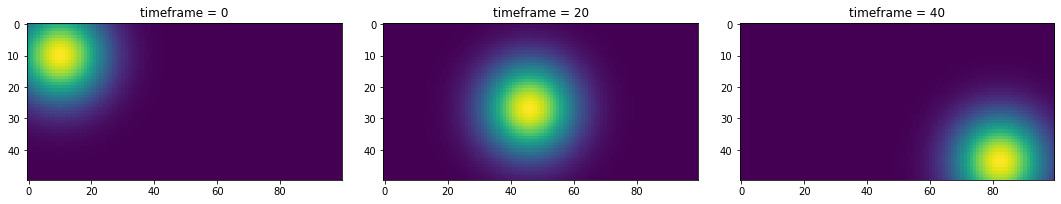

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 7))

fig.tight_layout()

ax1.imshow(test_data.data[0])
ax1.set_title('timeframe = 0')

ax2.imshow(test_data.data[20])
ax2.set_title('timeframe = 20')

ax3.imshow(test_data.data[40])
ax3.set_title('timeframe = 40')

This tells as that our data is a single wandering blob, which is what we are going the analyze with tobac now.

## Feature detection

The first step of the general working routine of tobac is the identification of features. This essentially means finding the maxima or minima of the data.

To use the according functions of tobac we need to specify:

- the thresholds below/above the features are detected
- the spacing of our data

The spacing of the temporal and spatial dimension can be extracted from the data using a build-in utility:

In [10]:
dxy, dt = tobac.utils.get_spacings(test_data)

To get an idea of which order of magnitude our thresholds should be, we check the maximum of our data:

In [11]:
test_data.max()

<xarray.DataArray 'w' ()>
array(10.)

Since we know that our data will only have one maximum it is reasoable to choose 9 as our threshold, but keep in mind that we could also add multiple values here if our data would be more complex.

In [12]:
threshold = 9

Now we are ready to apply the feature detection algorithm. Notice that this is a minimal input. The function has several other option we will cover in later tutorials.

In [13]:
%%capture
features = tobac.themes.tobac_v1.feature_detection_multithreshold(test_data, dxy, threshold)

Lets inpects the resulting object:

In [14]:
features

<xarray.Dataset>
Dimensions:                  (index: 51)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
Data variables: (12/13)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    hdim_1                   (index) float64 10.0 10.94 11.71 ... 48.15 48.6
    hdim_2                   (index) float64 10.0 11.85 13.66 ... 97.23 98.2
    num                      (index) int64 69 66 65 65 65 65 ... 39 34 23 13 5
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    time                     (index) object 2000-01-01 12:00:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:00:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1e+04 1.094e+04 ... 4.86e+04
    projection_x_coordinate  (index) float64 1e+04 1.185e+04 ... 9.82e+04
    latitude                 (index) object 24.1 24.12 24.14 ... 24.97 24.98
    longitude                (index) object 150.1 150.1 150.1 ... 150.5 150.5

The ouputs tells us that features were found in 51 **frame**s  (index 0 to 50) of our data. The variable **idx** is 1 for every frames, which means that only 1 feature was found in every time step, as we expected. **hdim_1** and **hdim_2** are the position of this feature with respect to the y and x-indices.

To vizualize this let's create masks for the frames we inspected before:

In [15]:
mask_1 = features['frame'] == 0
mask_2 = features['frame'] == 20
mask_3 = features['frame'] == 40

Now we can scatter the detected features onto the pictures we plotted:

Text(0.5, 1.0, 'timeframe = 40')

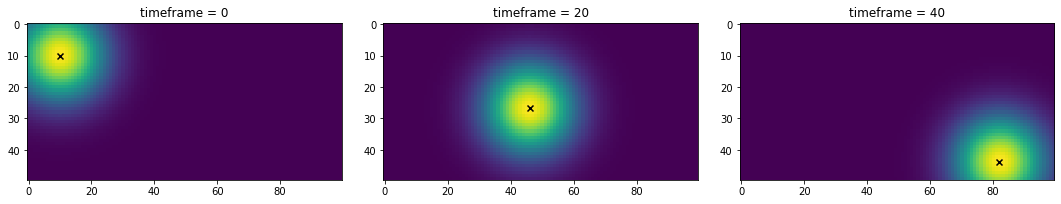

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 7))
fig.tight_layout()

ax1.imshow(test_data.data[0])
ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], color = 'black', marker = 'x')
ax1.set_title('timeframe = 0')

ax2.imshow(test_data.data[20])
ax2.scatter(features.where(mask_2)['hdim_2'], features.where(mask_2)['hdim_1'], color = 'black', marker = 'x')
ax2.set_title('timeframe = 20')

ax3.imshow(test_data.data[40])
ax3.scatter(features.where(mask_3)['hdim_2'], features.where(mask_3)['hdim_1'], color = 'black', marker = 'x')
ax3.set_title('timeframe = 40')

The function has succesfully detected the maximum of our data in the individual timeframes.

variable num?

The other variables are self-explanatory?

## Segmentation

The step after the feature detection is the segmentation of the data. This means we find the area sorounding our features belonging to the same cluster. Logically, we now need the allready detected features as an additional input.

In [17]:
%%capture
mask, features_test = tobac.themes.tobac_v1.segmentation(features, test_data, dxy, threshold=9)

As the name implies, the first object returned is a Boolean mask that is true for all segments belonging to features. The second output is again the features of the field.

In [18]:
mask

<xarray.DataArray 'segmentation_mask' (time: 100, y: 50, x: 100)>
[500000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    long_name:  segmentation_mask

Since True/False corresponds to 1/0 in python, we can visualize the segments with a simple contour plot:

Text(0.5, 1.0, 'timeframe = 40')

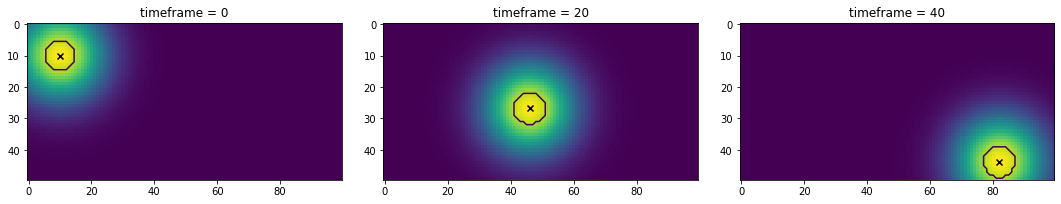

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 7))
fig.tight_layout()

ax1.imshow(test_data.data[0])
ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], color = 'black', marker = 'x')
ax1.contour(mask[0], levels = [0.5])
ax1.set_title('timeframe = 0')

ax2.imshow(test_data.data[20])
ax2.scatter(features.where(mask_2)['hdim_2'], features.where(mask_2)['hdim_1'], color = 'black', marker = 'x')
ax2.contour(mask[20], levels = [0.5])
ax2.set_title('timeframe = 20')

ax3.imshow(test_data.data[40])
ax3.scatter(features.where(mask_3)['hdim_2'], features.where(mask_3)['hdim_1'], color = 'black', marker = 'x')
ax3.contour(mask[40], levels = [0.5])
ax3.set_title('timeframe = 40')

Keep in mind that the area of the resulting segments crucially depends on the defined thresholds.

## Trajectory linking

After we are done finding the features and associated segments for each frame it is necessary for further analysis to keep track of those elements troughout time. Linking is the tool for that. It connects the features of the timesteps which belong together. We are going to use the *linking_trackpy()* function here. The required inputs are the features, the two spacings and a maximum velocity of the features.

In [20]:
track = tobac.themes.tobac_v1.linking_trackpy(features_test,test_data, dt=dt,dxy=dxy, v_max=100)

Frame 50: 1 trajectories present.


*fails without v_max*

Unsurprisingly, one trajectory was found. The returned object is another Dataset:

In [21]:
track

<xarray.Dataset>
Dimensions:                  (index: 51)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
Data variables: (12/16)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    hdim_1                   (index) float64 10.0 10.94 11.71 ... 48.15 48.6
    hdim_2                   (index) float64 10.0 11.85 13.66 ... 97.23 98.2
    num                      (index) int64 69 66 65 65 65 65 ... 39 34 23 13 5
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    projection_x_coordinate  (index) float64 1e+04 1.185e+04 ... 9.82e+04
    latitude                 (index) object 24.1 24.12 24.14 ... 24.97 24.98
    longitude                (index) object 150.1 150.1 150.1 ... 150.5 150.5
    ncells                   (index) float64 69.0 67.0 65.0 ... 23.0 13.0 5.0
    cell                     (index) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:50:00

The new variable cell now indexes the features in the different time steps. Therefore we can use it to create a mask for our moving feature:

In [22]:
track_mask = track['cell'] == 1.0

This mask can then be used to show the track in our plots:

Text(0.5, 1.0, 'timeframe = 40')

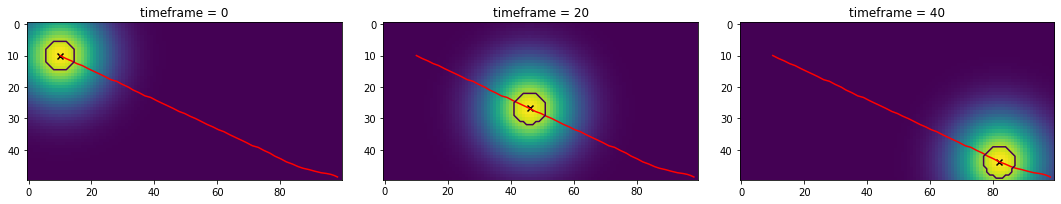

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 5))
fig.tight_layout()

ax1.imshow(test_data.data[0])
ax1.plot(track.where(track_mask)['hdim_2'], track.where(track_mask)['hdim_1'], 'r-')
ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], color = 'black', marker = 'x')
ax1.contour(mask[0], levels = [0.5])
ax1.set_title('timeframe = 0')

ax2.imshow(test_data.data[20])
ax2.plot(track.where(track_mask)['hdim_2'], track.where(track_mask)['hdim_1'], 'r-')
ax2.scatter(features.where(mask_2)['hdim_2'], features.where(mask_2)['hdim_1'], color = 'black', marker = 'x')
ax2.contour(mask[20], levels = [0.5])
ax2.set_title('timeframe = 20')

ax3.imshow(test_data.data[40])
ax3.plot(track.where(track_mask)['hdim_2'], track.where(track_mask)['hdim_1'], 'r-')
ax3.scatter(features.where(mask_3)['hdim_2'], features.where(mask_3)['hdim_1'], color = 'black', marker = 'x')
ax3.contour(mask[40], levels = [0.5])
ax3.set_title('timeframe = 40')

## Analysis

### Velocity

Now different functions of tobacs analysis module can be used to calculate or plot properties of the tracks and the features. For example the velocity of the feature along the track can be calulated via:

In [24]:
vel = tobac.analysis.calculate_velocity(track)

Plotting the velocity vs the timeframe will give us

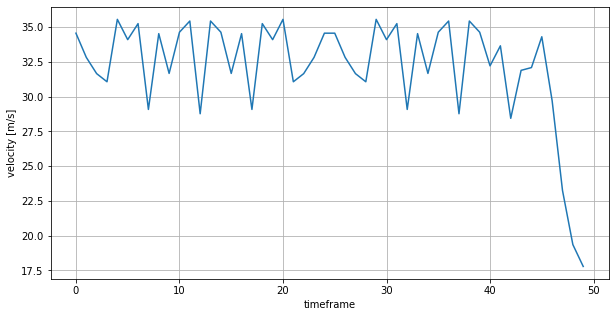

In [25]:
plt.figure(figsize = (10, 5))
plt.tight_layout()
plt.plot(vel['frame'], vel['v'])
plt.xlabel('timeframe')
plt.ylabel('velocity [m/s]')
plt.grid()

We can also create an histogram of the detected velocities:

In [26]:
hist, edges = tobac.analysis.velocity_histogram(track, bin_edges=np.arange(17, 36, 1),)

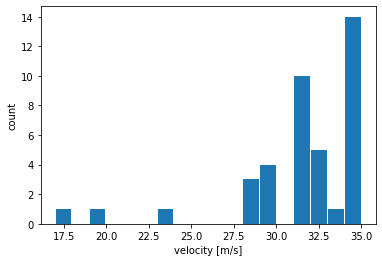

In [27]:
width = 0.9 * (edges[1] - edges[0])
center = (edges[:-1] + edges[1:]) / 2

plt.tight_layout()
plt.bar(center, hist, width=width)
plt.ylabel('count')
plt.xlabel('velocity [m/s]')
plt.show()

### Area

The area of the features can also be calculated and plotted throughout time:

In [28]:
area = tobac.analysis.calculate_area(features, mask)

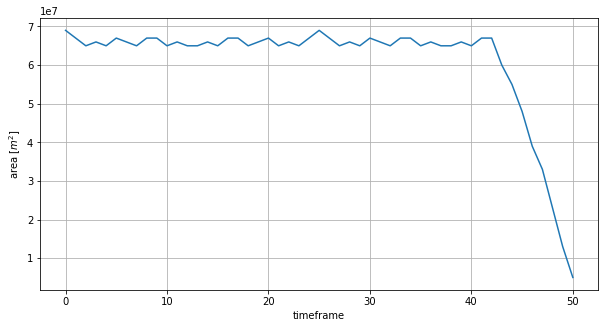

In [29]:
plt.figure(figsize = (10, 5))
plt.tight_layout()
plt.plot(area['frame'], area['area'])
plt.xlabel('timeframe')
plt.ylabel(r'area [$m^2$]')
plt.grid()

### Lifetime

Another interesting property for real data are the lifetimes of our features. Tobac can also produce a histgram of this:

In [30]:
hist, bins, centers = tobac.analysis.lifetime_histogram(track, bin_edges=np.arange(0, 200, 20))

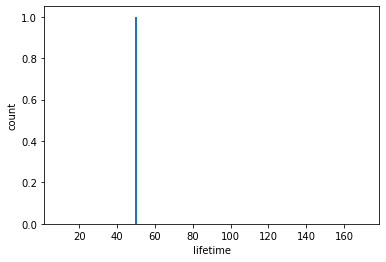

In [31]:
plt.tight_layout()
plt.bar(centers, hist, width=width)
plt.ylabel('count')
plt.xlabel('lifetime')
plt.show()

We can deduce, that our singular feature in the data has a lifetime of 50.